In [1]:
# Cell 1: 라이브러리 임포트 및 BaseModel 정의

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import numpy as np

# BaseModel 정의
class BaseModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True))
        
        self.conv1_M = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True))
        
        self.conv2_M = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True))
        
        self.conv3_M = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True))
        
        self.conv4_M = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True))
        
        self.GAP = nn.AdaptiveAvgPool2d(1)
        
        self.classifier = nn.Linear(512, 10)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv1_M(out)
        
        out = self.conv2(out)
        out = self.conv2_M(out)
        
        out = self.conv3(out)
        out = self.conv3_M(out)
        
        out = self.conv4(out)
        out = self.conv4_M(out)
        
        out = self.conv5(out)
        out = self.GAP(out)
        
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out


In [2]:
# Cell 2: 데이터 준비 및 전처리

# train과 test 데이터 디렉토리 경로 설정
train_dir = '/home/gidaseul/Documents/GitHub/ML_2/datas/MNIST/train'
test_dir = '/home/gidaseul/Documents/GitHub/ML_2/datas/MNIST/test'

# 데이터 전처리: MNIST 이미지를 RGB 채널로 처리
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 입력 크기를 모델에 맞게 조정 (BaseModel은 224x224 크기 가정)
    transforms.ToTensor(),        # 이미지를 텐서로 변환
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # RGB 정규화
])

# 데이터셋 로드
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

# 데이터셋 크기 확인
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

# 데이터 클래스 확인
print(f"Classes: {train_dataset.classes}")


Number of training samples: 450
Number of test samples: 50
Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [ ]:
# Cell 3: 학습 환경 설정 및 옵티마이저 정의

# 모델, 손실 함수, 옵티마이저 정의
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = BaseModel().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

# 조기 종료 파라미터 설정
early_stopping_patience = 10  # 개선되지 않으면 10 에폭 후 종료
best_test_loss = float('inf')  # 최적의 검증 손실
patience_counter = 0  # 개선되지 않은 에폭 수 카운트

# 모델 가중치 저장을 위한 경로
save_path = 'mnist_weightz.pth'


Using device: cuda


In [4]:
# Cell 4: Feature Extraction 및 평가 함수 정의

def extract_features(model, loader, device):
    features, labels_list = [], []
    model.eval()
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            # Conv-Blocks 통과
            out = model.conv1(images)
            out = model.conv1_M(out)

            out = model.conv2(out)
            out = model.conv2_M(out)

            out = model.conv3(out)
            out = model.conv3_M(out)

            out = model.conv4(out)
            out = model.conv4_M(out)

            out = model.conv5(out)
            out = model.GAP(out)
            latent = out.view(out.size(0), -1)

            features.append(latent.cpu().numpy())
            labels_list.extend(labels.cpu().numpy())

            # 메모리 정리
            del images, labels, out, latent
            torch.cuda.empty_cache()

    features = np.concatenate(features, axis=0)
    return features, np.array(labels_list)

def plot_tsne(features, labels, num_classes=10):
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(features)

    plt.figure(figsize=(10, 8))
    for class_idx in range(num_classes):
        idx = labels == class_idx
        plt.scatter(tsne_results[idx, 0], tsne_results[idx, 1], label=f'Class {class_idx}', alpha=0.6)
    plt.legend()
    plt.title("t-SNE Visualization of Features")
    plt.show()


Epoch [1/100]
Train Loss: 2.0588, Train Acc: 27.78%
Test Loss: 5.8099, Test Acc: 10.00%
Model weights saved.
Epoch [2/100]
Train Loss: 1.6490, Train Acc: 46.89%
Test Loss: 4.7120, Test Acc: 22.00%
Model weights saved.
Epoch [3/100]
Train Loss: 1.1950, Train Acc: 74.67%
Test Loss: 5.9434, Test Acc: 22.00%
Patience Counter: 1/10
Epoch [4/100]
Train Loss: 1.0251, Train Acc: 75.56%
Test Loss: 8.5895, Test Acc: 26.00%
Patience Counter: 2/10
Epoch [5/100]
Train Loss: 0.9769, Train Acc: 83.78%
Test Loss: 1.5692, Test Acc: 46.00%
Model weights saved.
Extracting features for t-SNE and clustering metrics...


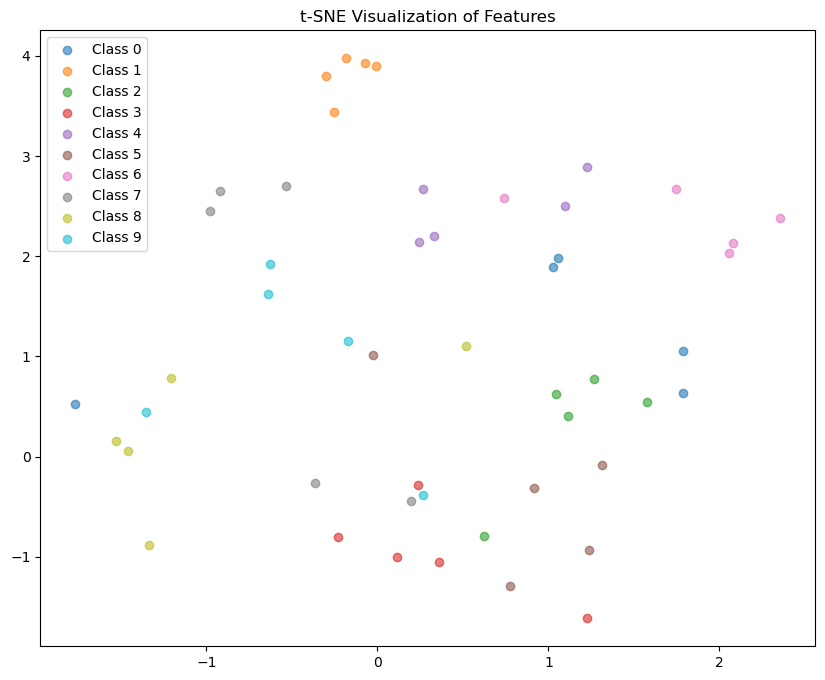

Silhouette Score: 0.1106, Davies-Bouldin Index: 1.6671
Epoch [6/100]
Train Loss: 0.8181, Train Acc: 89.33%
Test Loss: 0.8488, Test Acc: 68.00%
Model weights saved.
Epoch [7/100]
Train Loss: 0.8103, Train Acc: 89.33%
Test Loss: 2.1512, Test Acc: 50.00%
Patience Counter: 1/10
Epoch [8/100]
Train Loss: 0.6747, Train Acc: 91.11%
Test Loss: 2.2426, Test Acc: 40.00%
Patience Counter: 2/10
Epoch [9/100]
Train Loss: 0.7209, Train Acc: 91.11%
Test Loss: 11.5860, Test Acc: 20.00%
Patience Counter: 3/10
Epoch [10/100]
Train Loss: 0.8144, Train Acc: 79.78%
Test Loss: 3.8246, Test Acc: 26.00%
Patience Counter: 4/10
Extracting features for t-SNE and clustering metrics...


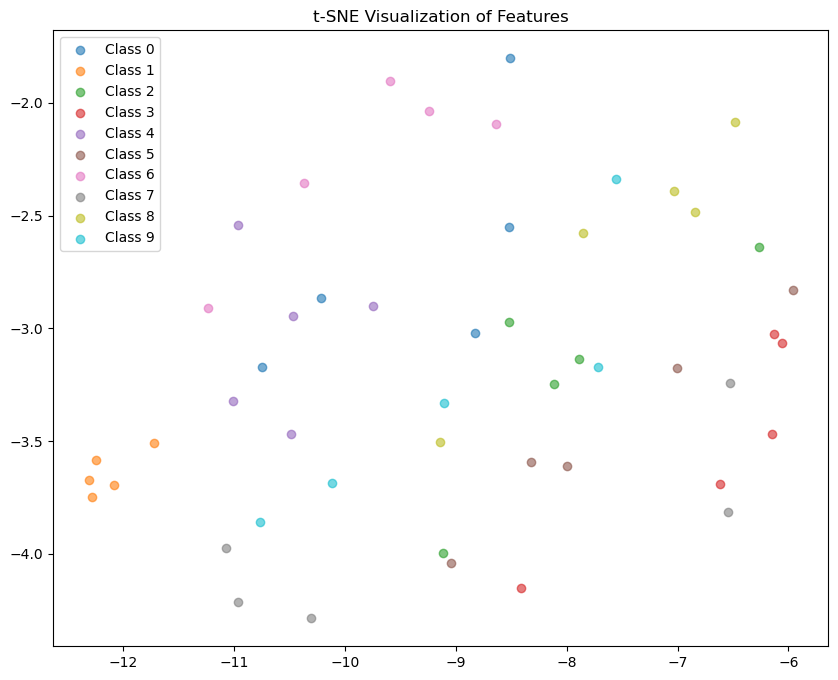

Silhouette Score: 0.0225, Davies-Bouldin Index: 2.1435
Epoch [11/100]
Train Loss: 0.6643, Train Acc: 89.78%
Test Loss: 2.2486, Test Acc: 42.00%
Patience Counter: 5/10
Epoch [12/100]
Train Loss: 0.6020, Train Acc: 89.33%
Test Loss: 2.1450, Test Acc: 46.00%
Patience Counter: 6/10
Epoch [13/100]
Train Loss: 0.6598, Train Acc: 92.67%
Test Loss: 1.1298, Test Acc: 58.00%
Patience Counter: 7/10
Epoch [14/100]
Train Loss: 0.4766, Train Acc: 96.22%
Test Loss: 0.5709, Test Acc: 84.00%
Model weights saved.
Epoch [15/100]
Train Loss: 0.5694, Train Acc: 93.78%
Test Loss: 0.8033, Test Acc: 78.00%
Patience Counter: 1/10
Extracting features for t-SNE and clustering metrics...


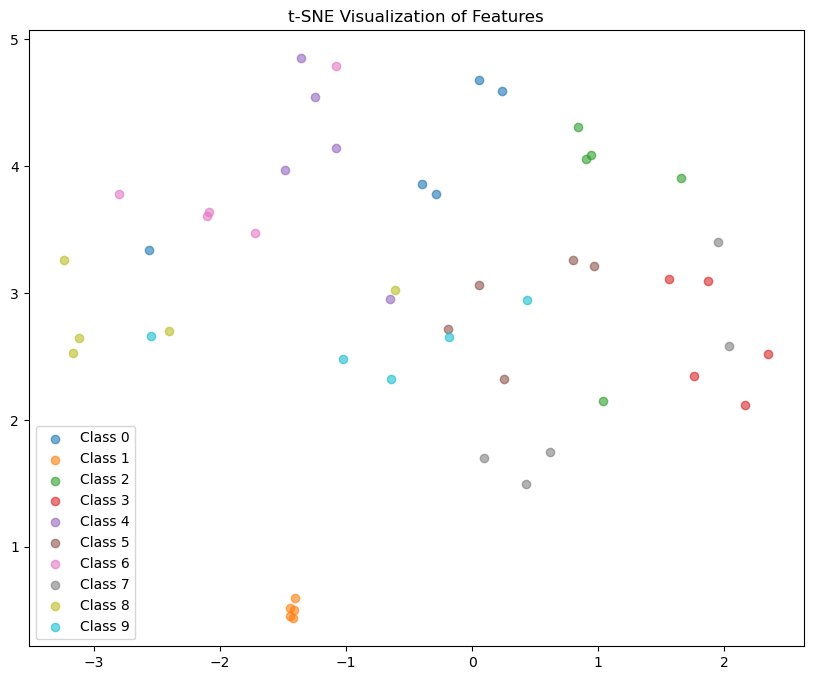

Silhouette Score: 0.2127, Davies-Bouldin Index: 1.3130
Epoch [16/100]
Train Loss: 0.5104, Train Acc: 92.22%
Test Loss: 1.9441, Test Acc: 50.00%
Patience Counter: 2/10
Epoch [17/100]
Train Loss: 0.3803, Train Acc: 94.22%
Test Loss: 0.8428, Test Acc: 76.00%
Patience Counter: 3/10
Epoch [18/100]
Train Loss: 0.3324, Train Acc: 94.67%
Test Loss: 1.0483, Test Acc: 66.00%
Patience Counter: 4/10
Epoch [19/100]
Train Loss: 0.4730, Train Acc: 95.78%
Test Loss: 0.4890, Test Acc: 82.00%
Model weights saved.
Epoch [20/100]
Train Loss: 0.2839, Train Acc: 96.44%
Test Loss: 0.6172, Test Acc: 84.00%
Patience Counter: 1/10
Extracting features for t-SNE and clustering metrics...


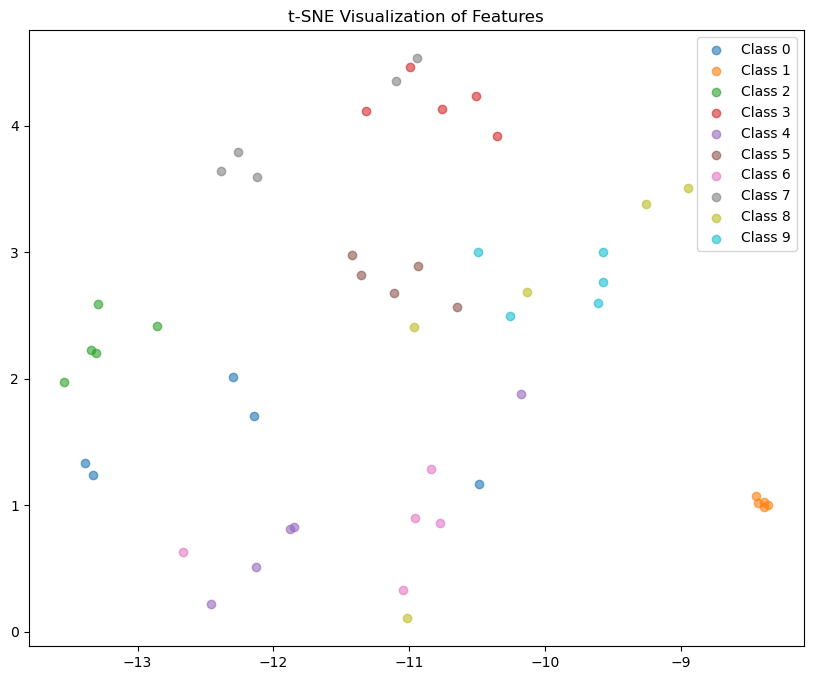

Silhouette Score: 0.2810, Davies-Bouldin Index: 1.1761
Epoch [21/100]
Train Loss: 0.4194, Train Acc: 96.22%
Test Loss: 0.4741, Test Acc: 90.00%
Model weights saved.
Epoch [22/100]
Train Loss: 0.2995, Train Acc: 97.33%
Test Loss: 0.6307, Test Acc: 78.00%
Patience Counter: 1/10
Epoch [23/100]
Train Loss: 0.2546, Train Acc: 96.67%
Test Loss: 0.4323, Test Acc: 88.00%
Model weights saved.
Epoch [24/100]
Train Loss: 0.3849, Train Acc: 97.11%
Test Loss: 0.3909, Test Acc: 90.00%
Model weights saved.
Epoch [25/100]
Train Loss: 0.2287, Train Acc: 98.00%
Test Loss: 0.3980, Test Acc: 86.00%
Patience Counter: 1/10
Extracting features for t-SNE and clustering metrics...


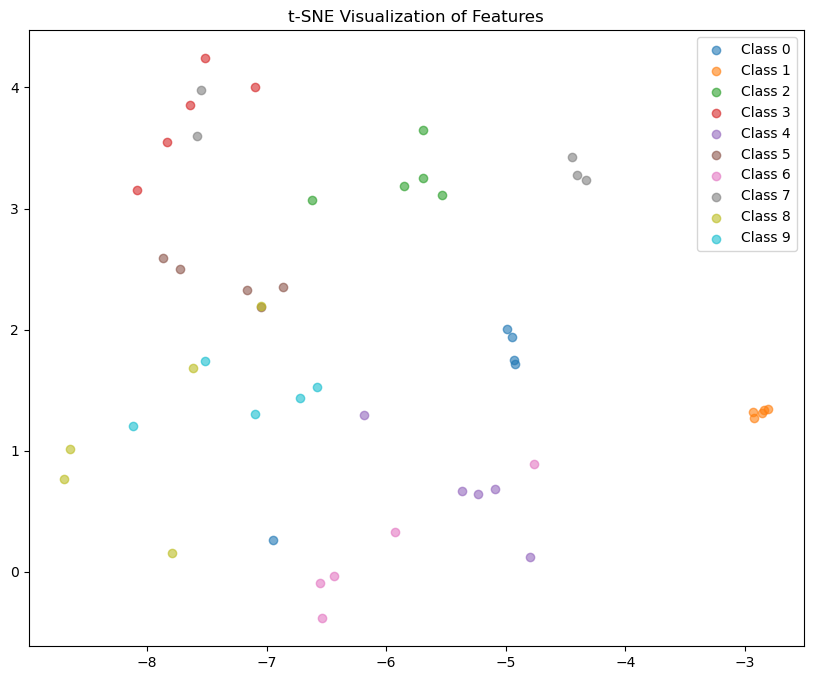

Silhouette Score: 0.3205, Davies-Bouldin Index: 1.0985
Epoch [26/100]
Train Loss: 0.1921, Train Acc: 97.56%
Test Loss: 0.6791, Test Acc: 76.00%
Patience Counter: 2/10
Epoch [27/100]
Train Loss: 0.2545, Train Acc: 98.00%
Test Loss: 0.3384, Test Acc: 84.00%
Model weights saved.
Epoch [28/100]
Train Loss: 0.3513, Train Acc: 96.89%
Test Loss: 0.3957, Test Acc: 86.00%
Patience Counter: 1/10
Epoch [29/100]
Train Loss: 0.2685, Train Acc: 96.67%
Test Loss: 1.1224, Test Acc: 62.00%
Patience Counter: 2/10
Epoch [30/100]
Train Loss: 0.2779, Train Acc: 96.67%
Test Loss: 0.4101, Test Acc: 88.00%
Patience Counter: 3/10
Extracting features for t-SNE and clustering metrics...


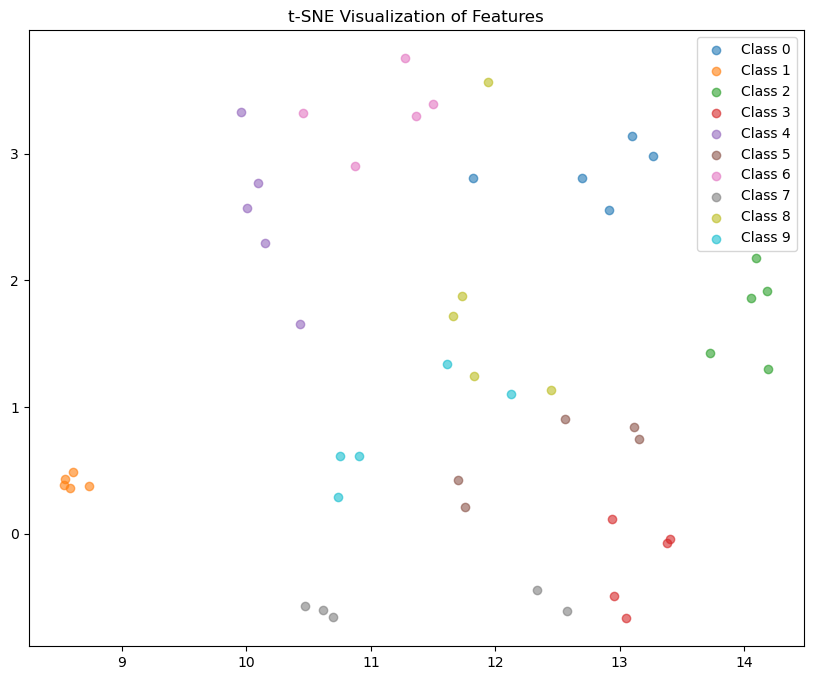

Silhouette Score: 0.3156, Davies-Bouldin Index: 1.0604
Epoch [31/100]
Train Loss: 0.1968, Train Acc: 98.00%
Test Loss: 0.4081, Test Acc: 88.00%
Patience Counter: 4/10
Epoch [32/100]
Train Loss: 0.3190, Train Acc: 98.22%
Test Loss: 0.3067, Test Acc: 90.00%
Model weights saved.
Epoch [33/100]
Train Loss: 0.2365, Train Acc: 98.00%
Test Loss: 0.2783, Test Acc: 92.00%
Model weights saved.
Epoch [34/100]
Train Loss: 0.4532, Train Acc: 98.44%
Test Loss: 0.3031, Test Acc: 90.00%
Patience Counter: 1/10
Epoch [35/100]
Train Loss: 0.2735, Train Acc: 98.44%
Test Loss: 0.3127, Test Acc: 88.00%
Patience Counter: 2/10
Extracting features for t-SNE and clustering metrics...


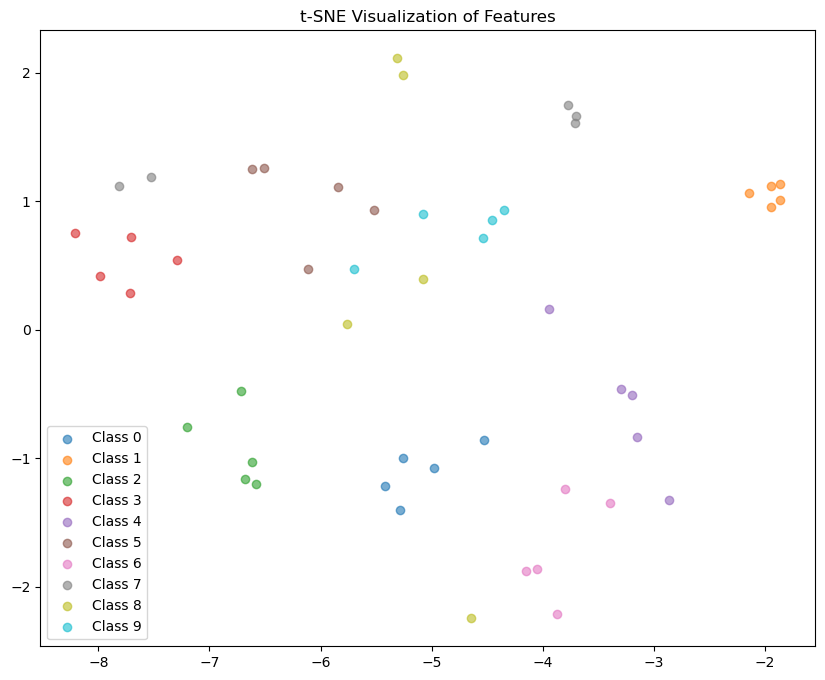

Silhouette Score: 0.3545, Davies-Bouldin Index: 1.0125
Epoch [36/100]
Train Loss: 0.1792, Train Acc: 98.00%
Test Loss: 0.3356, Test Acc: 88.00%
Patience Counter: 3/10
Epoch [37/100]
Train Loss: 0.1819, Train Acc: 98.44%
Test Loss: 0.3053, Test Acc: 86.00%
Patience Counter: 4/10
Epoch [38/100]
Train Loss: 0.2079, Train Acc: 98.44%
Test Loss: 0.3102, Test Acc: 86.00%
Patience Counter: 5/10
Epoch [39/100]
Train Loss: 0.2485, Train Acc: 99.11%
Test Loss: 0.2671, Test Acc: 92.00%
Model weights saved.
Epoch [40/100]
Train Loss: 0.3017, Train Acc: 98.89%
Test Loss: 0.2545, Test Acc: 94.00%
Model weights saved.
Extracting features for t-SNE and clustering metrics...


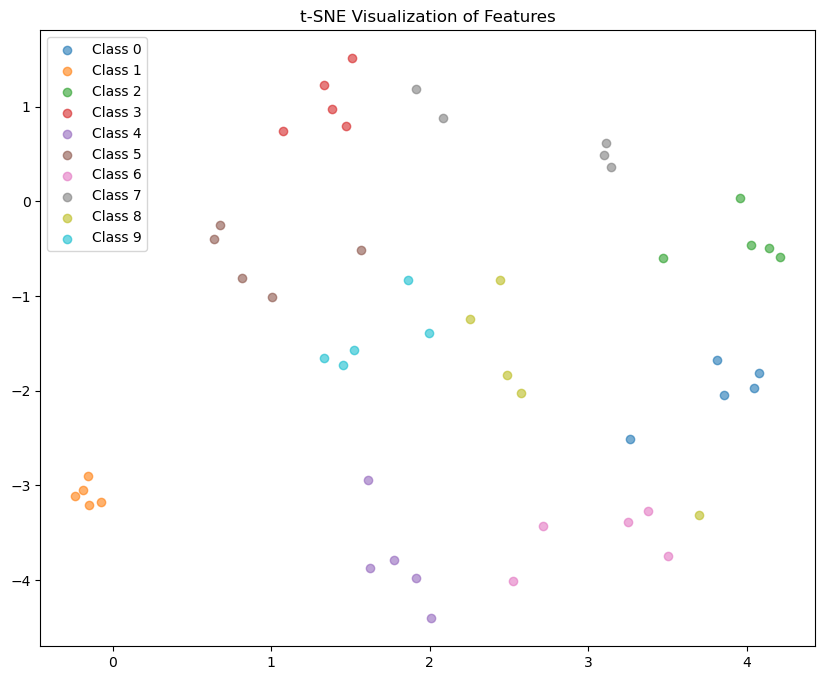

Silhouette Score: 0.3788, Davies-Bouldin Index: 0.9766
Epoch [41/100]
Train Loss: 0.2658, Train Acc: 99.56%
Test Loss: 0.2309, Test Acc: 92.00%
Model weights saved.
Epoch [42/100]
Train Loss: 0.2181, Train Acc: 99.56%
Test Loss: 0.2482, Test Acc: 94.00%
Patience Counter: 1/10
Epoch [43/100]
Train Loss: 0.1328, Train Acc: 99.56%
Test Loss: 0.2788, Test Acc: 88.00%
Patience Counter: 2/10
Epoch [44/100]
Train Loss: 0.1761, Train Acc: 99.11%
Test Loss: 0.2624, Test Acc: 90.00%
Patience Counter: 3/10
Epoch [45/100]
Train Loss: 0.2275, Train Acc: 97.78%
Test Loss: 0.2506, Test Acc: 92.00%
Patience Counter: 4/10
Extracting features for t-SNE and clustering metrics...


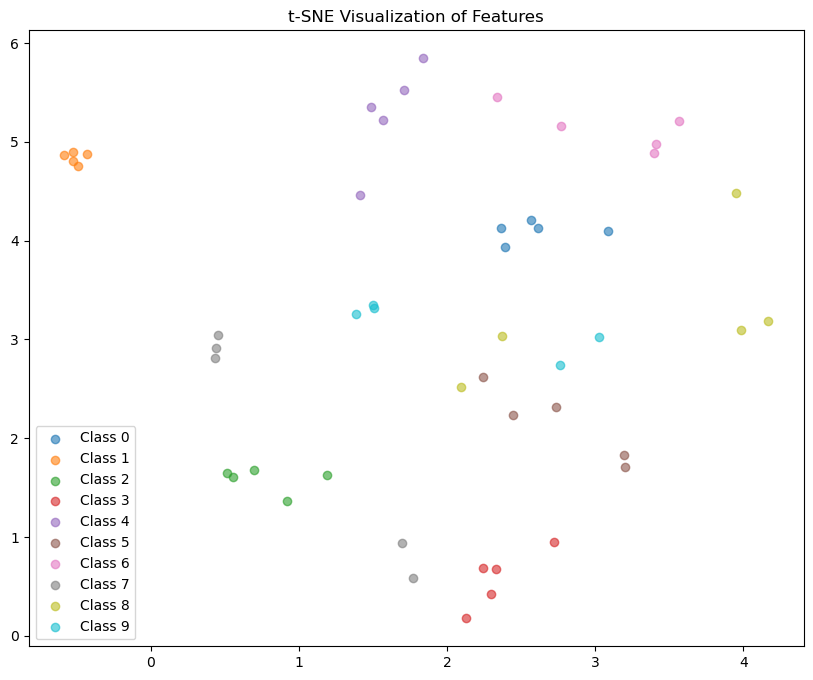

Silhouette Score: 0.3774, Davies-Bouldin Index: 0.9863
Epoch [46/100]
Train Loss: 0.3008, Train Acc: 99.56%
Test Loss: 0.2284, Test Acc: 94.00%
Model weights saved.
Epoch [47/100]
Train Loss: 0.1568, Train Acc: 99.56%
Test Loss: 0.2174, Test Acc: 98.00%
Model weights saved.
Epoch [48/100]
Train Loss: 0.1328, Train Acc: 99.78%
Test Loss: 0.2306, Test Acc: 94.00%
Patience Counter: 1/10
Epoch [49/100]
Train Loss: 0.2274, Train Acc: 99.33%
Test Loss: 0.2571, Test Acc: 90.00%
Patience Counter: 2/10
Epoch [50/100]
Train Loss: 0.1595, Train Acc: 100.00%
Test Loss: 0.2448, Test Acc: 92.00%
Patience Counter: 3/10
Extracting features for t-SNE and clustering metrics...


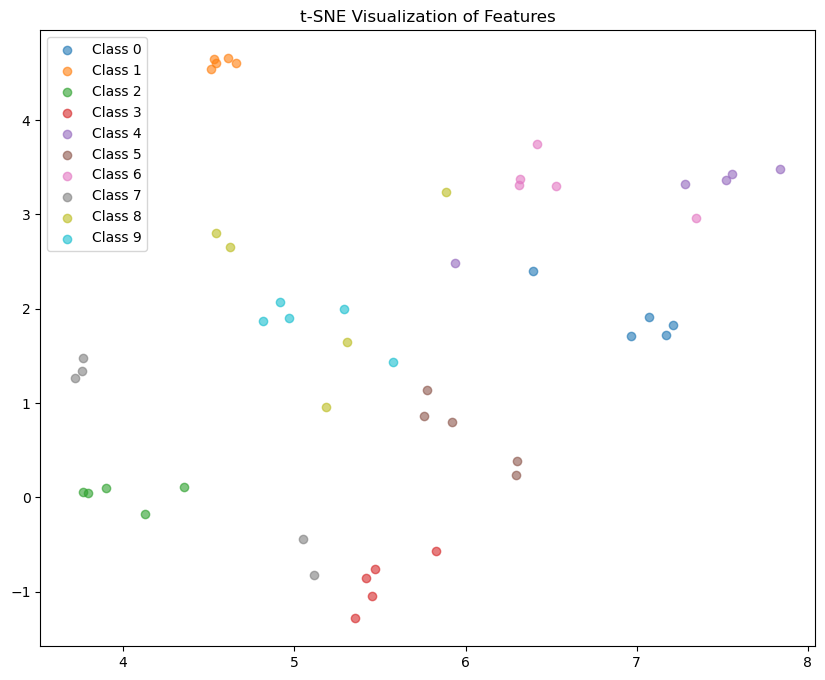

Silhouette Score: 0.3827, Davies-Bouldin Index: 0.9787
Epoch [51/100]
Train Loss: 0.1518, Train Acc: 99.33%
Test Loss: 0.2408, Test Acc: 94.00%
Patience Counter: 4/10
Epoch [52/100]
Train Loss: 0.1374, Train Acc: 99.33%
Test Loss: 0.2359, Test Acc: 94.00%
Patience Counter: 5/10
Epoch [53/100]
Train Loss: 0.1663, Train Acc: 99.78%
Test Loss: 0.2428, Test Acc: 96.00%
Patience Counter: 6/10
Epoch [54/100]
Train Loss: 0.1607, Train Acc: 99.33%
Test Loss: 0.2426, Test Acc: 96.00%
Patience Counter: 7/10
Epoch [55/100]
Train Loss: 0.1100, Train Acc: 100.00%
Test Loss: 0.2412, Test Acc: 96.00%
Patience Counter: 8/10
Extracting features for t-SNE and clustering metrics...


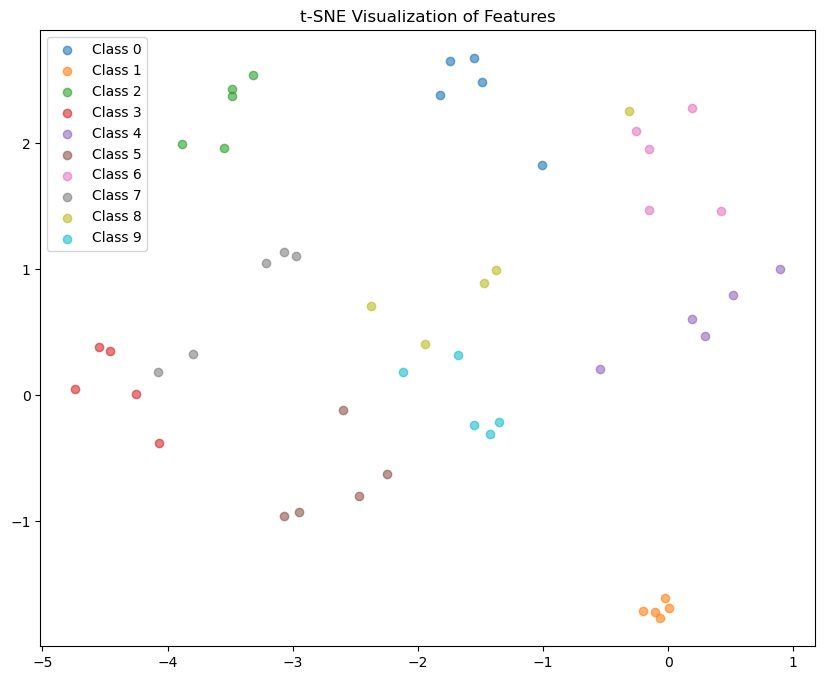

Silhouette Score: 0.3792, Davies-Bouldin Index: 0.9804
Epoch [56/100]
Train Loss: 0.1484, Train Acc: 100.00%
Test Loss: 0.2536, Test Acc: 88.00%
Patience Counter: 9/10
Epoch [57/100]
Train Loss: 0.3796, Train Acc: 99.56%
Test Loss: 0.2490, Test Acc: 88.00%
Patience Counter: 10/10
Early stopping at epoch 57


In [5]:
# Cell 5: 메인 학습 루프

for epoch in range(100):
    # Training Loop
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # 메모리 정리
        del images, labels, outputs, loss
        torch.cuda.empty_cache()

    train_acc = 100 * correct / total
    train_loss = running_loss / len(train_loader)

    # Evaluation Loop
    model.eval()
    test_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # 메모리 정리
            del images, labels, outputs, loss
            torch.cuda.empty_cache()

    test_acc = 100 * correct / total
    test_loss = test_loss / len(test_loader)

    print(f"Epoch [{epoch+1}/100]")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

    # 학습률 조정 (ReduceLROnPlateau 사용)
    scheduler.step(test_loss)

    # test_loss 개선 시 가중치 저장
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        patience_counter = 0  # 개선이 있었으므로 카운터 초기화
        torch.save(model.state_dict(), save_path)  # 모델 가중치 저장
        print("Model weights saved.")
    else:
        patience_counter += 1
        print(f"Patience Counter: {patience_counter}/{early_stopping_patience}")

    # Early Stopping 체크
    if patience_counter >= early_stopping_patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

    # 5 에폭마다 t-SNE 시각화 및 군집화 지표 계산
    if (epoch + 1) % 5 == 0:
        print("Extracting features for t-SNE and clustering metrics...")
        test_features, test_labels = extract_features(model, test_loader, device)

        # t-SNE 시각화
        plot_tsne(test_features, test_labels, num_classes=10)

        # Silhouette Score 및 Davies-Bouldin Index 계산
        silhouette = silhouette_score(test_features, test_labels)
        dbi = davies_bouldin_score(test_features, test_labels)
        print(f"Silhouette Score: {silhouette:.4f}, Davies-Bouldin Index: {dbi:.4f}")


In [6]:
# Cell 6: Latent Classifier 정의

# Latent Classifier 정의
class LatentClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.fc(x)


In [7]:
# Cell 7: Latent Feature 추출 및 TensorDataset 변환

# 모델 가중치 로드 (필요 시)
model.load_state_dict(torch.load(save_path))
model.to(device)
model.eval()

# Latent Feature 추출
print("Extracting train features...")
train_features, train_labels = extract_features(model, train_loader, device)
print("Extracting test features...")
test_features, test_labels = extract_features(model, test_loader, device)

# TensorDataset으로 변환
train_features = torch.tensor(train_features, dtype=torch.float32)
train_labels = torch.tensor(train_labels, dtype=torch.long)
test_features = torch.tensor(test_features, dtype=torch.float32)
test_labels = torch.tensor(test_labels, dtype=torch.long)

train_dataset_latent = torch.utils.data.TensorDataset(train_features, train_labels)
test_dataset_latent = torch.utils.data.TensorDataset(test_features, test_labels)

# DataLoader 생성
train_loader_latent = torch.utils.data.DataLoader(train_dataset_latent, batch_size=64, shuffle=True)
test_loader_latent = torch.utils.data.DataLoader(test_dataset_latent, batch_size=64, shuffle=False)

print(f"Number of training latent samples: {len(train_dataset_latent)}")
print(f"Number of test latent samples: {len(test_dataset_latent)}")


Extracting train features...


/tmp/ipykernel_39302/1347501849.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))


Extracting test features...
Number of training latent samples: 450
Number of test latent samples: 50


In [ ]:
# Cell 8: Latent Classifier 학습

# Latent Classifier 초기화
latent_classifier = LatentClassifier(input_dim=train_features.shape[1], num_classes=10).to(device)
criterion_latent = nn.CrossEntropyLoss()
optimizer_latent = optim.Adam(latent_classifier.parameters(), lr=0.001)

# Latent Classifier 학습 루프
num_epochs = 50
for epoch in range(num_epochs):
    # Training Loop
    latent_classifier.train()
    running_loss, correct, total = 0.0, 0, 0
    for features, labels in train_loader_latent:
        features, labels = features.to(device), labels.to(device)

        optimizer_latent.zero_grad()
        outputs = latent_classifier(features)
        loss = criterion_latent(outputs, labels)
        loss.backward()
        optimizer_latent.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # 메모리 정리
        del features, labels, outputs, loss
        torch.cuda.empty_cache()

    train_acc = 100 * correct / total
    train_loss = running_loss / len(train_loader_latent)

    # Evaluation Loop
    latent_classifier.eval()
    test_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for features, labels in test_loader_latent:
            features, labels = features.to(device), labels.to(device)
            outputs = latent_classifier(features)
            loss = criterion_latent(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # 메모리 정리
            del features, labels, outputs, loss
            torch.cuda.empty_cache()

    test_acc = 100 * correct / total
    test_loss = test_loss / len(test_loader_latent)

    print(f"Latent Classifier Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")


Latent Classifier Epoch [1/50]
Train Loss: 1.8409, Train Acc: 76.89%
Test Loss: 1.4079, Test Acc: 88.00%
Latent Classifier Epoch [2/50]
Train Loss: 1.0820, Train Acc: 87.33%
Test Loss: 0.8244, Test Acc: 92.00%
Latent Classifier Epoch [3/50]
Train Loss: 0.4975, Train Acc: 99.33%
Test Loss: 0.5089, Test Acc: 90.00%
Latent Classifier Epoch [4/50]
Train Loss: 0.2643, Train Acc: 98.22%
Test Loss: 0.3797, Test Acc: 84.00%
Latent Classifier Epoch [5/50]
Train Loss: 0.1601, Train Acc: 98.67%
Test Loss: 0.3203, Test Acc: 86.00%
Latent Classifier Epoch [6/50]
Train Loss: 0.1098, Train Acc: 98.89%
Test Loss: 0.2735, Test Acc: 88.00%
Latent Classifier Epoch [7/50]
Train Loss: 0.1056, Train Acc: 99.11%
Test Loss: 0.2534, Test Acc: 88.00%
Latent Classifier Epoch [8/50]
Train Loss: 0.1002, Train Acc: 99.11%
Test Loss: 0.2576, Test Acc: 88.00%
Latent Classifier Epoch [9/50]
Train Loss: 0.0645, Train Acc: 99.33%
Test Loss: 0.3029, Test Acc: 88.00%
Latent Classifier Epoch [10/50]
Train Loss: 0.0718, Tra

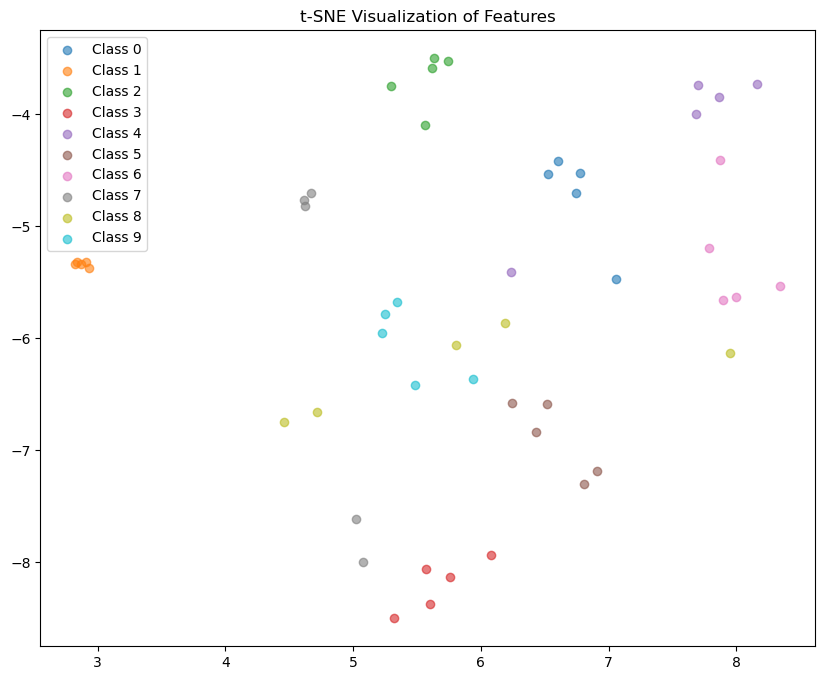

Silhouette Score: 0.3786, Davies-Bouldin Index: 0.9784


In [ ]:
# Cell 10: Latent Feature를 사용한 추가 분석 (예: t-SNE, 분류기 학습 등)
# Latent Feature 추출: 저장된 모델 가중치를 사용하여 테스트 데이터의 Latent Feature를 추출합니다.
# t-SNE 시각화: 추출된 Feature를 2차원으로 축소하여 시각화합니다.
# 군집화 지표 계산: Silhouette Score와 Davies-Bouldin Index를 계산하여 Latent Space의 군집화 품질을 평가합니다.

# 예시: 이미 저장된 모델 가중치를 로드한 후 Latent Feature 추출 및 시각화
# model = BaseModel().to(device)
# model.load_state_dict(torch.load('model_weights.pth'))
# model.eval()

# Latent Feature 추출
test_features, test_labels = extract_features(model, test_loader, device)

# t-SNE 시각화
plot_tsne(test_features, test_labels, num_classes=10)

# 군집화 지표 계산
silhouette = silhouette_score(test_features, test_labels)
dbi = davies_bouldin_score(test_features, test_labels)
print(f"Silhouette Score: {silhouette:.4f}, Davies-Bouldin Index: {dbi:.4f}")
